In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
import pickle
%matplotlib widget

In [2]:
class SimParams(object):
    def __init__(self, N = 100, n_steps=10000, n_analyze = 5000, n_burnin = 2000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.1, n_trials = 10, snapshots = False):
        self.N = N
        self.n_steps = n_steps
        self.n_analyze = n_analyze
        self.n_burnin = n_burnin
        self.b_top = b_top
        self.multiprocess = multiprocess
        self.t_min = t_min
        self.t_max = t_max
        self.t_step = t_step
        self.n_trials = n_trials
        self.snapshots = snapshots
    def param_str(self):
        return f"N:{self.N} n_steps:{self.n_steps} n_analyze:{self.n_analyze} n_burnin:{self.n_burnin} b_top:{self.b_top} multiprocess:{'t' if self.multiprocess else 'f'} t_min:{self.t_min} t_max:{self.t_max} t_step:{self.t_step}"

def _run_raw(test_path, params: SimParams):
    #!cd .. && python ising.py N:{params.N} multiprocess:{"t" if params.multiprocess else "f"} b_top:{params.b_top} t_min:{params.t_min} t_max:{params.t_max} t_step:{params.t_step} n_steps:{params.n_steps} n_analyze:{params.n_analyze} n_burnin:{params.n_burnin}
    !cd .. && python ising.py {params.param_str()}

def copy_results(test_path, params: SimParams):
    !mv ../data/* {test_path}/result/
    if params.snapshots:
        !mv ../snapshots/* {test_path}/snapshots/

def store_metadata(test_path, params: SimParams):
    with open(f"{test_path}/metadata.txt", "w") as f:
        f.write(f"n_trials: {params.n_trials}\n")
        f.write(f"snapshots taken: {params.snapshots}\n")
        f.write(f"param string: {params.param_str()}\n")
    # Pickle the params object and store it into params.pkl
    with open(f"{test_path}/params.pkl", "wb") as f:
        pickle.dump(params, f)
        
#def rerun(test_path, snapshots=False, params: SimParams = SimParams()):
#    _run_raw(test_path, snapshots, params)
#    copy_results(test_path, snapshots)
#    store_metadata(test_path, snapshots, 1, params)
        
def run_many(test_path, params: SimParams = SimParams()):
    for i in range(params.n_trials):
        _run_raw(test_path, params)
    copy_results(test_path, params)
    store_metadata(test_path, params)

def new_test(test_path):
    !mkdir -p {test_path}/result
    !mkdir -p {test_path}/snapshots
    !mkdir -p {test_path}/plots
    

In [69]:
data_tests = "../../data_tests"
test_name = "fit-observables/grace-33"
test_path = f"{data_tests}/{test_name}"

if False:
    params = SimParams(N = 100, n_steps=108000, n_analyze=100000, n_burnin=5000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.02, n_trials = 31)
    
    new_test(test_path)
    run_many(test_path, params=params)
else:
    # Unpack the params from params.pkl so we always have the right param values
    with open(f"{test_path}/params.pkl", "rb") as f:
        params = pickle.load(f)
    #params = SimParams(N = 100, n_steps=200000, n_analyze=100000, n_burnin=2000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.1)

# Make this variable at global scope
n_trials = params.n_trials

In [67]:
# Read data from files
em = []
sc = []
ac = []

for trial in range(n_trials):
    print(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_EM_v{trial}.csv")
    em.append(pd.read_csv(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_EM_v{trial}.csv", skiprows=3))
    sc.append(pd.read_csv(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_SC_v{trial}.csv", skiprows=3))
    ac = sc # If we aren't taking autocorrelation every step
    # ac = pd.read_csv("data/0.00T5.00_AC_v0.csv", skiprows=3)

../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v0.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v1.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v2.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v3.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v4.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v5.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v6.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v7.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v8.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v9.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v10.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v11.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v12.csv
../../data_tests/fit-observables/grace-33/result/1.60T3.60_EM_v13.csv
../../data_tests/fit-observabl

EmptyDataError: No columns to parse from file

In [7]:
# Extract numpy arrays from dataframes

temp_size = len(em[0])
# shape: (temp)
temp = np.empty(len(em[0]))
temp[:] = em[0]["Temp"].to_numpy() # All temperatures are the same for all trials

# shape: (temp, trial)
e_mean = np.empty((temp_size, n_trials))
e_std = np.empty_like(e_mean)
m_mean = np.empty_like(e_mean)
m_std = np.empty_like(e_mean)

for trial in range(n_trials):
    e_mean[:, trial] = em[trial]["E_mean"].to_numpy()
    e_std[:, trial] = em[trial]["E_std"].to_numpy()
    m_mean[:, trial] = em[trial]["M_mean"].to_numpy()
    m_std[:, trial] = em[trial]["M_std"].to_numpy()
    
e_var = e_std ** 2
m_var = m_std ** 2

# shape: (temp, lattice_dist, trial)
sc_data = np.empty((len(temp), len(sc[0].columns) - 2, n_trials))
ac_data = np.empty((len(temp), len(sc[0].columns) - 2, n_trials))

for trial in range(n_trials):
    for lattice_dist, col_name in enumerate(sc[0].columns[1:-1]):
        sc_data[:, lattice_dist, trial] = sc[trial][col_name]
        ac_data[:, lattice_dist, trial] = ac[trial][col_name]
        
print(f"Test: {test_name}.\n{e_mean.size} runs ({temp_size} temperatures * {n_trials} trials each) in {temp[0]} <= T <= {temp[-1]}")
print(f"temp.shape = {temp.shape}, sc_data.shape = {sc_data.shape}, ac_data.shape = {ac_data.shape}")

Test: fit-observables/many-runs-trial-3-fixN.
200 runs (20 temperatures * 10 trials each) in 1.6 <= T <= 3.5000000000000018
temp.shape = (20,), sc_data.shape = (20, 49, 10), ac_data.shape = (20, 49, 10)


In [8]:
e_mean_error = e_std.mean(axis=1) / np.sqrt(n_trials)
m_mean_error = m_std.mean(axis=1) / np.sqrt(n_trials)

In [43]:
pcw_sinh = lambda T : (T < 2.269) * ((1 - np.sinh(2 / T) ** (-4)) ** (1 / 8))

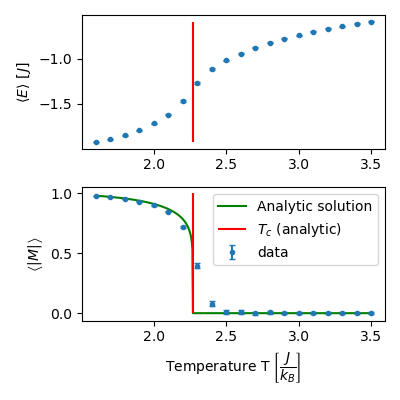

In [51]:
plt.close()
fig, ax = plt.subplots(2, figsize=(4, 4))

ax[0].errorbar(temp, e_mean.mean(axis=1), e_mean_error, fmt='.', capsize=2)
#ax[0].set_xlabel(r"Temperature $\left[\dfrac{k_B T}{J}\right]$")
ax[0].set_ylabel(r"$\left<E\right>$ $\left[\, J\right]$")

x = np.linspace(temp[0], temp[-1], 500)
ax[1].plot(x, np.piecewise(x, [x < 2.269, x >= 2.269], [pcw_sinh, 0]), color="green", label="Analytic solution")

ax[0].vlines(2.269, e_mean.mean(axis=1).min(), e_mean.mean(axis=1).max(), colors='r', linestyles='solid', label="$T_c$ (analytic)")
ax[1].vlines(2.269, 0, 1, colors='r', linestyles='solid', label="$T_c$ (analytic)")

ax[1].errorbar(temp, m_mean.mean(axis=1), m_mean_error, fmt='.', label="data", capsize=2)
ax[1].set_ylabel(r"$\left<|M|\right>$")

ax[1].set_xlabel(r"Temperature T $\left[\dfrac{J}{k_B}\right]$")
ax[1].legend()

fig.tight_layout()
plt.savefig(f"{test_path}/plots/EMplots.png")

In [10]:
e_var_avg = e_var.mean(axis=1)
e_var_error = e_var.std(axis=1) / np.sqrt(n_trials)
m_var_avg = m_var.mean(axis=1)
m_var_error = m_var.std(axis=1) / np.sqrt(n_trials)

cv = params.N ** 2 * e_var_avg / temp ** 2
cv_error = cv * e_var_error / e_var_avg # Propagate error in cv
chi = params.N ** 2 * m_var_avg / temp
chi_error = chi * m_var_error / m_var_avg # Propagate error in chi

In [11]:
partition_radius = 0.1 # In units of T
analytic_T_c = 2.269
# 2.269 is the analytic critical temperature for the 2D Ising model
partition_l = temp.searchsorted(analytic_T_c - partition_radius) + 1
partition_r = temp.searchsorted(analytic_T_c + partition_radius)

In [12]:
# Underconstrained fit to cv to determine T_c

log = lambda T, a, b, T_c: a + b * np.log(np.abs((T - T_c) / T_c))

cv_p_pos, cv_covm_pos = curve_fit(log, temp[partition_r:], cv[partition_r:], p0 = (0, -1, analytic_T_c), sigma=cv[partition_r:])
cv_p_neg, cv_covm_neg = curve_fit(log, temp[:partition_l], cv[:partition_l], p0 = (0, -1, analytic_T_c), sigma=cv_error[:partition_l])

cv_var_pos = np.sqrt(np.diag(cv_covm_pos))
cv_var_neg = np.sqrt(np.diag(cv_covm_neg))
cv_corr_pos = cv_covm_pos / np.outer(cv_var_pos, cv_var_pos)
cv_corr_neg = cv_covm_neg / np.outer(cv_var_neg, cv_var_neg)

print(f"Left: T_c = {cv_p_neg[2]:.3f} ± {cv_var_neg[2]:.3f}, amplitude = {cv_p_neg[1]:.3f} ± {cv_var_neg[1]:.3f}, offset = {cv_p_neg[0]:.3f} ± {cv_var_neg[0]:.3f}")
print(f"T_c & amplitude: {cv_corr_neg[1, 2]:.3f}; T_c & offset: {cv_corr_neg[0, 2]:.3f}; amplitude & offset: {cv_corr_neg[0, 1]:.3f}")
print(f"Right: T_c = {cv_p_pos[2]:.3f} ± {cv_var_pos[2]:.3f}, amplitude = {cv_p_pos[1]:.3f} ± {cv_var_pos[1]:.3f}, offset = {cv_p_pos[0]:.3f} ± {cv_var_pos[0]:.3f}")
print(f"T_c & amplitude: {cv_corr_pos[1, 2]:.3f}; T_c & offset: {cv_corr_pos[0, 2]:.3f}; amplitude & offset: {cv_corr_pos[0, 1]:.3f}")

Left: T_c = 2.285 ± 0.026, amplitude = -0.602 ± 0.051, offset = -0.448 ± 0.050
T_c & amplitude: -0.933; T_c & offset: -0.859; amplitude & offset: 0.982
Right: T_c = 2.328 ± 0.017, amplitude = -0.296 ± 0.016, offset = 0.040 ± 0.010
T_c & amplitude: 0.882; T_c & offset: 0.533; amplitude & offset: 0.835


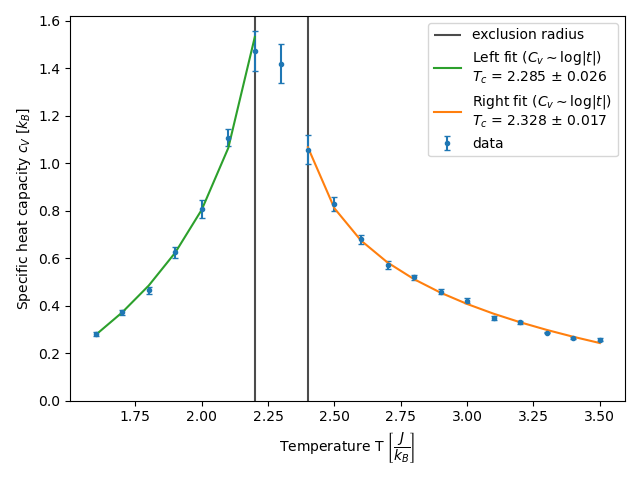

In [59]:
# Plot cv with both fits

plt.close()
fig, ax = plt.subplots()

ax.set_ylim(0, cv.max() * 1.1)

ax.vlines([temp[partition_l - 1], temp[partition_r]], 0, cv.max() * 1.1, linestyles="solid", color="black", alpha=0.7, label="exclusion radius")
#ax.vlines(analytic_T_c, 0, cv.max() * 1.1, linestyles="solid", color="red", label="$T_c$ (analytic)")
#ax.vlines(cv_p_neg[2], 0, cv.max() * 1.1, linestyles="dashed", color="tab:green", label=f"$T_c$ (left fit) = {cv_p_neg[2]:.3f}")
#ax.vlines(cv_p_pos[2], 0, cv.max() * 1.1, linestyles="dashed", color="tab:orange", label=f"$T_c$ (right fit) = {cv_p_pos[2]:.3f}")

ax.errorbar(temp, cv, yerr=cv_error, fmt=".", label="data", capsize=2)
ax.plot(temp[:partition_l], log(temp[:partition_l], *cv_p_neg), color="tab:green", label=f"Left fit ($C_v \sim \log |t|$)\n$T_c$ = {cv_p_neg[2]:.3f} ± {cv_var_neg[2]:.3f}")
ax.plot(temp[partition_r:], log(temp[partition_r:], *cv_p_pos), color="tab:orange", label=f"Right fit ($C_v \sim \log |t|$)\n$T_c$ = {cv_p_pos[2]:.3f} ± {cv_var_pos[2]:.3f}")

ax.legend()
ax.set_xlabel(r"Temperature T $\left[\dfrac{J}{k_B}\right]$")
ax.set_ylabel(r"Specific heat capacity $c_V$ $\left[k_B\right]$")
fig.tight_layout()

In [14]:
# Underconstrained fit to chi to determine T_c

chi_powerlaw = lambda T, a, gamma, T_c: a * np.abs((T - T_c) / T_c)**(-gamma)

chi_p, chi_covm = curve_fit(chi_powerlaw, temp[partition_r:], chi[partition_r:], p0 = (1, 1, analytic_T_c), sigma=chi_error[partition_r:])
#chi_p_neg, chi_covm_neg = curve_fit(chi_powerlaw, temp[:partition_l], chi[:partition_l], p0 = (1, 1, analytic_T_c), sigma=chi_error[:partition_l])
chi_variance = np.sqrt(np.diag(chi_covm))
chi_corrm = chi_covm / np.outer(chi_variance, chi_variance)

print(f"T_c = {chi_p[2]:.2f} ± {chi_variance[2]:.2f} gamma = {chi_p[1]:.2f} ± {chi_variance[1]:.2f}; amplitude = {chi_p[0]:.2f} ± {chi_variance[0]:.2f}")
print(f"T_c & gamma = {chi_corrm[1, 2]:.2f}; T_c & amplitude = {chi_corrm[0, 2]:.2f}; gamma & amplitude = {chi_corrm[0, 1]:.2f}")

T_c = 2.27 ± 0.05 gamma = 1.22 ± 0.14; amplitude = 0.70 ± 0.04
T_c & gamma = -0.92; T_c & amplitude = 0.30; gamma & amplitude = -0.63


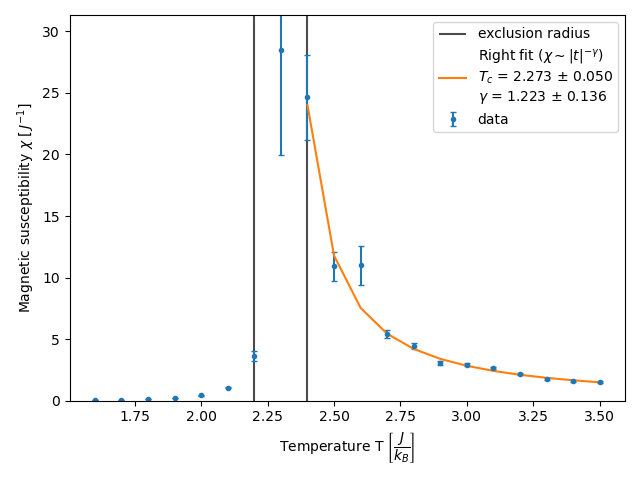

In [57]:
# Plot chi with fit

plt.close()
fig, ax = plt.subplots()

ax.set_ylim(0, chi.max() * 1.1)

ax.vlines([temp[partition_l - 1], temp[partition_r]], 0, chi.max() * 1.1, linestyles="solid", color="black", alpha=0.7, label="exclusion radius")
#ax.vlines(analytic_T_c, 0, chi.max() * 1.1, linestyles="solid", color="tab:red", label=f"$T_c$ (analytic) = {analytic_T_c:.3f}")
#ax.vlines(chi_p[2], 0, chi.max() * 1.1, linestyles="dashed", color="tab:green", label=f"$T_c$ (fit) = {chi_p[2]:.3f}")

ax.errorbar(temp, chi, yerr=chi_error, fmt=".", color="tab:blue", label="data", capsize=2)
ax.plot(temp[partition_r:], chi_powerlaw(temp[partition_r:], *chi_p), color="tab:orange", label=(r"Right fit ($\chi \sim |t|^{-\gamma}$)" + f"\n$T_c$ = {chi_p[2]:.3f} ± {chi_variance[2]:.3f}\n$\gamma$ = {chi_p[1]:.3f} ± {chi_variance[1]:.3f}"))

ax.legend()
ax.set_xlabel(r"Temperature T $\left[\dfrac{J}{k_B}\right]$")
ax.set_ylabel(r"Magnetic susceptibility $\chi$ $\left[ \,J^{-1} \right]$")
fig.tight_layout()

### TODO

- [x] Fit function to M
- [ ] Format figure 3 (cv and chi)
- [ ] Figure 4: autocorrelation
  - [ ] Autocorrelation functions at different temperatures
  - [ ] Fit decay(xi) to each autocorrelation function for each trial
  - [ ] Plot xi against temperature w/ error bars across trials
- [ ] Fit critical exponents with analytical T_c

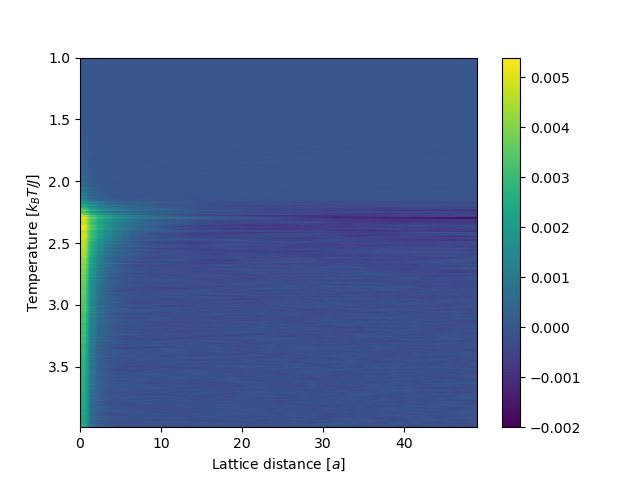

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(sc_data, aspect="auto", extent=[0, sc_data.shape[1], temp[-1], temp[0]])
ax.set_ylabel("Temperature $[k_B T / J]$")
ax.set_xlabel("Lattice distance $[a]$")
fig.colorbar(im)

In [16]:
decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
A = np.empty_like(temp)
xi = np.empty_like(temp)
x = np.arange(sc_data.shape[1])

for i in np.arange(len(temp)):
    if np.abs(sc_data[i, :]).max() != 0:
        (val_A, val_xi), covm = curve_fit(decay, x, sc_data[i, :], p0=(sc_data[i, 0], 1e0))
    else:
        val_A, val_xi = 0, 0
    A[i] = val_A
    xi[i] = val_xi if np.abs(val_xi) < sc_data.shape[1] else 0
    

print(f"xi.shape = {xi.shape}, A.shape = {A.shape}")
print(f"xi.min = {xi.min()}, xi.max = {xi.max()}")

xi.shape = (300,), A.shape = (300,)
xi.min = 0.0, xi.max = 5.058530611585292


/var/folders/h6/326nqt2x2ql8ggvhjlhhckh40000gn/T/ipykernel_94980/3491209615.py:1: RuntimeWarning: overflow encountered in exp
  decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
/Users/adrianhall/miniconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [17]:
winsize = 20
wincenter = winsize // 2
window = np.full(winsize, 1/winsize)
mav_xi = fftconvolve(xi, window, mode="same")
mvstd_xi = fftconvolve((xi - mav_xi)**2, window, mode="same")**0.5
mav_A = fftconvolve(A, window, mode="same")
mvstd_A = fftconvolve((A - mav_A)**2, window, mode="same")**0.5
mavdomain = slice(wincenter, -(wincenter - 1))
print(mav_xi.shape, mav_A.shape, mavdomain)

(300,) (300,) slice(10, -9, None)


Text(0, 0.5, 'Correlation length $\\xi$')

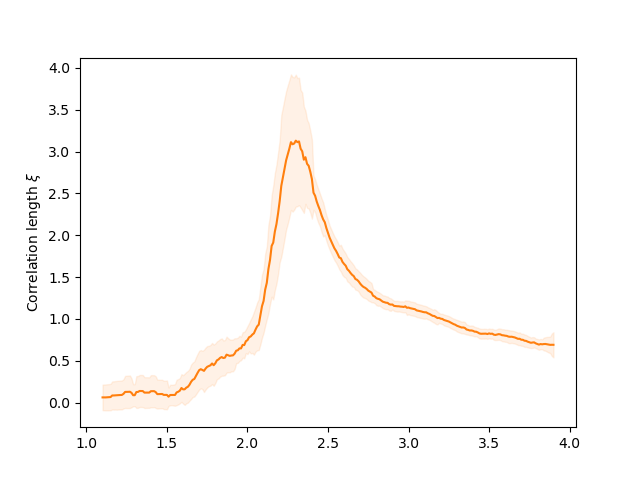

In [22]:
fig, ax = plt.subplots()
#ax2 = ax.twinx()
# ax.plot(temp[mavdomain], mav_A[mavdomain], label="A", color="tab:blue")
# ax.fill_between(temp[mavdomain], mav_A[mavdomain] + mvstd_A[mavdomain], mav_A[mavdomain] - mvstd_A[mavdomain], color="tab:blue", alpha=0.1)
# ax.yaxis.label.set_color("tab:blue")
# ax2.spines["left"].set_edgecolor("tab:blue")
# ax.set_ylabel("A")
ax.plot(temp[mavdomain], mav_xi[mavdomain], label="xi", color="tab:orange")
ax.fill_between(temp[mavdomain], mav_xi[mavdomain] + mvstd_xi[mavdomain], mav_xi[mavdomain] - mvstd_xi[mavdomain], color="tab:orange", alpha=0.1)
ax.set_ylabel("Correlation length $\\xi$")

2.3000000000000003 3.384398532732046


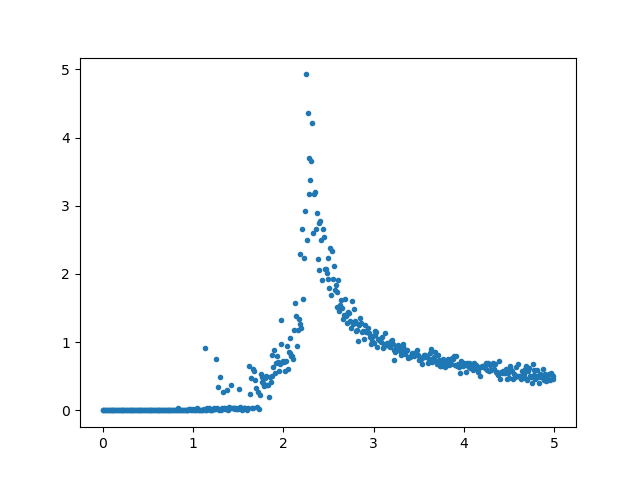

In [404]:
plt.close()
fig, ax = plt.subplots()
ax.scatter(temp, xi, marker=".")
print(temp[230], xi[230])

Test: bsanity/sanity. T = 2.26J, Fit = 2.72e-03exp(- x / 2.50)


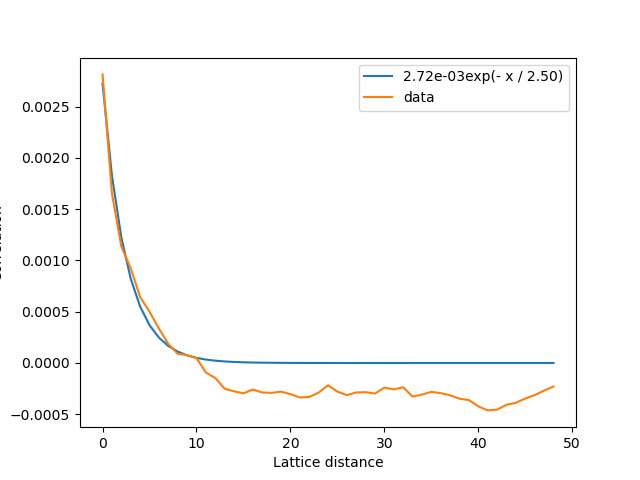

In [411]:
plt.close()
fig, ax = plt.subplots()
idx = temp.searchsorted(2.26)
#print(A[i], xi[i])
ax.plot(x, decay(x, A[idx], xi[idx]), label=f"{A[idx]:.2e}exp(- x / {xi[idx]:.2f})")
ax.plot(x, sc_data[idx], label="data")
ax.set_xlabel("Lattice distance")
ax.set_ylabel("Correlation")
# ax.plot(temp[tstart:tend], A, label="A")
# ax.plot(temp[tstart:tend], xi, label="xi")
ax.legend()
print(f"Test: {test_name}. T = {temp[idx]:.2f}J, Fit = {A[idx]:.2e}exp(- x / {xi[idx]:.2f})")

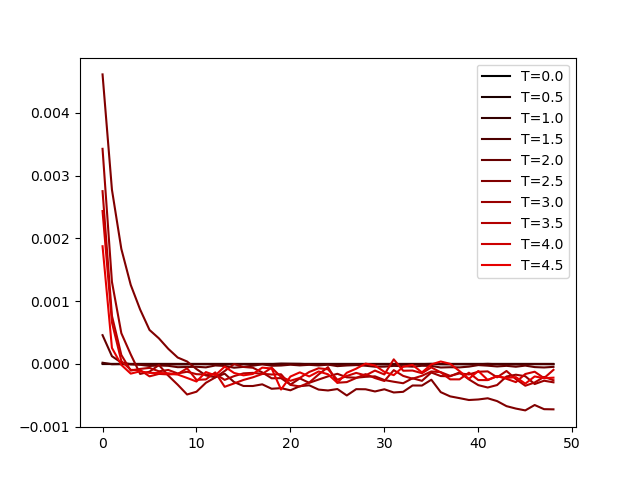

In [406]:


fig, ax = plt.subplots()
for i in np.arange(tstart, tend, (tend - tstart) // 10):
    ax.plot(sc_data[i, :], label=f"T={temp[i]}", color=(temp[i]/5, 0, 0))
    
ax.legend()